In [1]:
import math

import pandas as pd
from qiskit.providers.fake_provider import FakeQasmSimulator
from qiskit.compiler import transpile
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.quantum_info.operators import Operator


backend_architecture = FakeQasmSimulator()
cfg = backend_architecture.configuration()

In [2]:
def get_mct_cx_count(n:int, mode:str='noancilla', optimization_level:int=3) -> int:
    """
    Get the number of CX gates in an MCT gate

    :param n: number of control qubits
    :param mode: mct gate mode as per https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.mct.html
    :param optimization_level: optimization mode used during transpilation. Zero is the least optimal, three is the most optimal.
    :return: the number of CX gates
    """
    control = QuantumRegister(n)
    ancilla = QuantumRegister(max(1, n-2))
    target = QuantumRegister(1)
    circuit = QuantumCircuit(control, target, ancilla)
    circuit.mct(control_qubits=control, target_qubit=target[0], ancilla_qubits=ancilla, mode=mode)
    optimized_circuit = transpile(circuit, coupling_map=cfg.coupling_map, basis_gates=['u', 'cx'], optimization_level=optimization_level)
    return optimized_circuit.count_ops()['cx']

In [4]:
def get_cs_cx_count(r:int, optimization_level:int=3) -> int:
    """
    Get the number of CX gates in CS gate (worst case scenario)

    :param r: number of strings in the database
    :param optimization_level: optimization mode used during transpilation. Zero is the least optimal, three is the most optimal.
    :return: the number of cx gates
    """
    _x = r # worst case scenario
    cs = Operator([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, math.sqrt((_x - 1) / _x), 1 / (math.sqrt(_x))],
        [0, 0, -1 / (math.sqrt(_x)), math.sqrt((_x - 1) / _x)]
    ])
    circuit = QuantumCircuit(QuantumRegister(2))
    circuit.unitary(cs, [1, 0], label='cs')
    optimized_circuit = transpile(circuit, coupling_map=cfg.coupling_map, basis_gates=['u', 'cx'], optimization_level=optimization_level)
    return optimized_circuit.count_ops()['cx']

Two functions above can give us the number of rotational `u` and CNOT `cx` gates. Here are examples:

In [5]:
get_mct_cx_count(5, mode='noancilla')

92

In [6]:
get_mct_cx_count(5, mode='recursion')

56

In [7]:
get_mct_cx_count(5, mode='v-chain-dirty')

38

In [8]:
get_mct_cx_count(5, mode='v-chain')

24

In [9]:
get_cs_cx_count(1000)

2

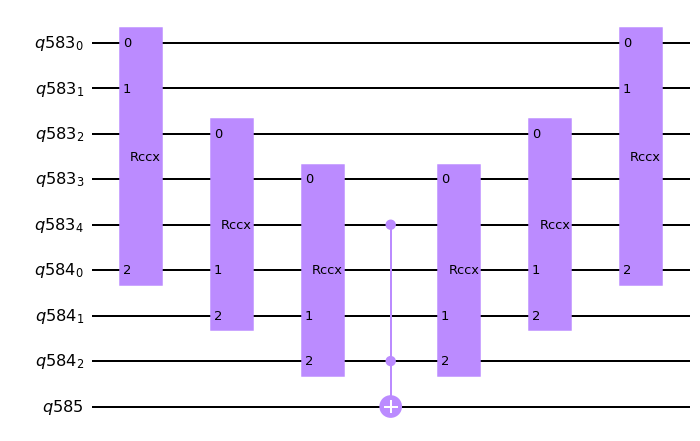

In [10]:
# example of v-chain decomposition
control = QuantumRegister(5)
ancilla = QuantumRegister(3)
target = QuantumRegister(1)
circuit = QuantumCircuit(control, ancilla, target)
circuit.mct(control_qubits=control, target_qubit=target[0], ancilla_qubits=ancilla, mode='v-chain')
circuit.decompose().draw(output='mpl')

Note that `v-chain` gives the lowest number of CNOT gates, but I am not certain if we can assume that ancilla qubits will always be clean. If we can adopt definition of a clean ancilla qubit "An ancillary qubit is called clean if it starts in a known computational basis state and is restored to that state after the computation. It is called dirty if it starts in an unknown state which must be restored after the computation." by Malvetti et al., 2021, then we can use `v-chain`. Otherwise we should use `v-chain-dirty`.

See Fig.4.10 of Nielsen and Chuang, 2010 for example of V-chain. Notice that they require $n-1$ ancilla qubits, $2(n-1)$ Toffoli gates and $1$ CNOT gate. In Qiskit's code this is further reduced to $n-2$ ancilla gubits and only  $2(n-1)$ simiplified Toffoli gates (`rccx`) which are unraveled to 3 CNOT gates each (see example above, [docs](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RCCXGate.html) and [code](https://github.com/Qiskit/qiskit-terra/blob/5b166c05182ca3c062106d08a9610ac246aa3e83/qiskit/circuit/library/standard_gates/x.py#L1198-L1202) for details).

In the QisKit case of `v-chain`, `mct` "unravels" to $6(n-1)$ gates (optimizer somehow gets rid of $1$ Toffoli gate) , where $n$ is the number of control qubits. In our case $n$ coincides with the string length.

Let's perform worst-case scenario analysis. We will set $\gamma = 1$ and assume that the database is complete, i.e., $r = 2^n$.

**ToDo**: Set optimization level to 3

In [10]:
gamma = 1  # worst-case scenario

out = []
for string_length_n in range(1,15):
    # EP-PQM. Use the gate count from Table 1 of https://arxiv.org/pdf/2201.07265.pdf
    string_count_r = pow(2, string_length_n)  # full database
    cx_gate_count = 2 * gamma * string_length_n * string_count_r
    eppqm_cx_gate_count_wo_ancilla = cx_gate_count + get_cs_cx_count(string_length_n) * string_count_r + get_mct_cx_count(string_length_n) * 2 * string_count_r
    # TODO: set optimization level to 3
    eppqm_cx_gate_count_w_ancilla = cx_gate_count + get_cs_cx_count(string_length_n) * string_count_r + get_mct_cx_count(string_length_n, mode='v-chain', optimization_level=0) * 2 * string_count_r

    # statevector algorithm by Shende et al. [https://arxiv.org/pdf/quant-ph/0406176.pdf p.3]
    statevector_cx_gate_count = math.ceil( 23.0/48.0 * pow(4, string_length_n) - 3.0/2.0 * pow(2, string_length_n) + 4.0/3.0)

    # one of the theoretical boundaries by Shende et al. [https://arxiv.org/pdf/quant-ph/0406176.pdf p.3]
    statevector_one_cx_gate_count = pow(2, string_length_n + 1) - 2 * string_length_n

    # sparce state vector generation algorithm by Malvetti et al. as per Table 1 of https://quantum-journal.org/papers/q-2021-03-15-412/pdf/

    s = math.ceil(math.log2(string_count_r))
    sparse_statevector_wo_ancilla = math.ceil((string_length_n + 16 * s - 9) * string_count_r + 23.0/24.0 * pow(2, s))
    sparse_statevector_w_ancilla = math.ceil((string_length_n + 6 * s - 7) * string_count_r + 23.0/24.0 * pow(2, s))

    out.append({
        'string_length_n':  string_length_n,
        'eppqm_cx_gate_count_wo_ancilla': eppqm_cx_gate_count_wo_ancilla,
        'eppqm_cx_gate_count_w_ancilla': eppqm_cx_gate_count_w_ancilla,
        'statevector_cx_gate_count': statevector_cx_gate_count,
        'statevector_one_cx_gate_count': statevector_one_cx_gate_count,
        'sparse_statevector_wo_ancilla': sparse_statevector_wo_ancilla,
        'sparse_statevector_w_ancilla': sparse_statevector_w_ancilla,
    })

df = pd.DataFrame(out)

## Worst-case scenario analysis
### CNOT gate count
The results (shown in graphical and tabular form below) suggest the following.

* If EP-PQM MCT gate is implemented without ancilla qubits then the Statevector approach implemented in QisKit [1, 2] will outperform it at least for $n \le 15$. Invocation of `get_mct_cx_count` becomes slow with the increase of $n$. We may check the paper describing MCT `noancilla` mode to see if they have an estimate on the growth of the CNOT gates.
* If EP-PQM MCT gate is implemented with ancilla qubits (using 'v-chain-dirty' algorithm) then EP-PQM will outperform the Statevector approach implemented in QisKit [1, 2] for $n \ge 9$. Note that this approach will require $n-2$ ancilla qubits [3].
* Both EP-PQM and Statevector approach are inferior to an optimal bound described in [1, page 3] (not certain if this is an ultimate optimal bound or if it can be lowered further, need to read [1] carefully).
* Sparse statevectore [4] is superior to EP-PQM with ancilla (and it seems that they may also need lesser number of ancilla qubits). Let's see if this is true for all $r$.

ToDo: There may already be a more efficient method for dense statevector to circuit conversion. Review [4] to see if there are other more efficient methods.

### Ancilla qubits
* EP-PQM (in the case of MCT with ancilla qubits) will need $n-2$ ancilla qubits [3], while Sparse Statevector [4] only $\approx \log_2(r) / 2 -1$ qubits. In the worst case scenario, when $r = 2^n$, it needs less than EP-PQM case, i.e., $\approx n / 2 -1$

### Time to generate the circuit
So far we showed that sparce statevector gives a more efficient circuit and needs lesser number of ancilla qubits. However, EP-PQM needs siginifcantly less time to generate the circuit. Based on [5, Algorithm 4], EP-PQM needs $O(nr)$ operations to construct the circuit. Sparse statevector, based on [4, Section 5.2] requires $O\left( {n \choose s} + n 2^{2s} \right)$, where $s = \lceil log_2{(r)} \rceil$.

Let's explore two extreme cases:
1. Consider the  case when $r = 1$. Then $s = 0$ and Sparse statevector time complexity is $O(1 + n 2^{0}) = O(n)$. EP-PQM time complexity will also be $O(n)$.
2. Consider the  case when $r = 2^n$. Then $s = n$ and Sparse statevector time complexity is $O(1 + n 2^{2n}) = O(n 2^{2n})$. EP-PQM time complexity will be only $O(n 2^n)$.

Thus, EP-PQM becomes faster than Sparse Statevector with the increase of $r$. See numerical example below for $n=10$ (results are given in `operations_cnt` array). As we can see, time complexity growth extremely fast.

## References
1. Shende et al., [preprint](https://arxiv.org/pdf/quant-ph/0406176.pdf)
2. QisKit [tutorial](https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/circuits/3_summary_of_quantum_operations.ipynb)
3. QisKit [manual](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.mct.html)
4. Malvetti et al., [preprint](https://quantum-journal.org/papers/q-2021-03-15-412/pdf/)
5. Khan et al., [preprint](https://arxiv.org/pdf/2201.07265.pdf)

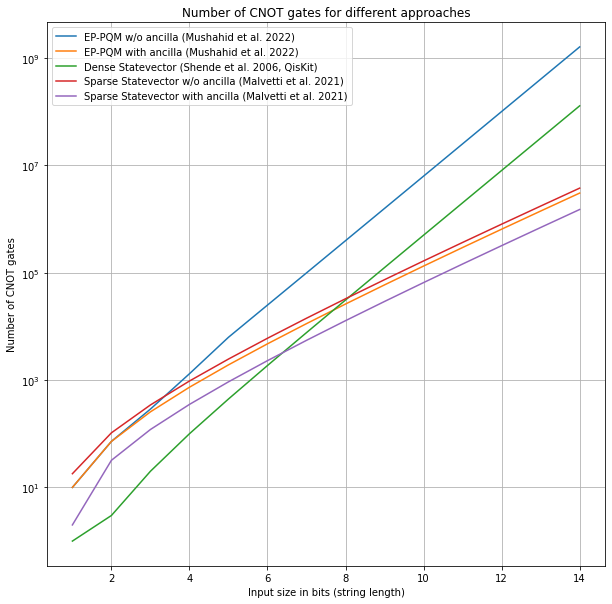

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(df['string_length_n'], df['eppqm_cx_gate_count_wo_ancilla'], label='EP-PQM w/o ancilla (Mushahid et al. 2022)')
plt.plot(df['string_length_n'], df['eppqm_cx_gate_count_w_ancilla'], label='EP-PQM with ancilla (Mushahid et al. 2022)')
plt.plot(df['string_length_n'], df['statevector_cx_gate_count'], label='Dense Statevector (Shende et al. 2006, QisKit)')
plt.plot(df['string_length_n'], df['sparse_statevector_wo_ancilla'], label='Sparse Statevector w/o ancilla (Malvetti et al. 2021)')
plt.plot(df['string_length_n'], df['sparse_statevector_w_ancilla'], label='Sparse Statevector with ancilla (Malvetti et al. 2021)')
#plt.plot(df['string_length_n'], df['statevector_one_cx_gate_count'], label='Statevector (an optimal bound)')
plt.xlabel('Input size in bits (string length)')
plt.ylabel('Number of CNOT gates')
plt.title('Number of CNOT gates for different approaches')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [12]:
df


,string_length_n,eppqm_cx_gate_count_wo_ancilla,eppqm_cx_gate_count_w_ancilla,statevector_cx_gate_count,statevector_one_cx_gate_count,sparse_statevector_wo_ancilla,sparse_statevector_w_ancilla
0,1,10,10,1,2,18,2
1,2,72,72,3,4,104,32
2,3,288,256,20,10,344,120
3,4,1312,736,100,24,960,352
4,5,6272,1920,444,54,2463,927
5,6,24960,4736,1868,116,6014,2302
6,7,99328,11264,7660,242,14203,5499
7,8,395776,26112,31020,496,32758,12790
8,9,1579008,59392,124844,1006,74219,29163
9,10,6305792,133120,500908,2028,165846,65494


In [13]:
# TODO: 1. plot qubit count vs. input size for all algorithms
# TODO: 2. find if for dense statevector there is an algorithm using ancilla qubits. Add it to the plots above
# TODO: 3. plot min number of strings (2^{n-1}} in db needed for a given statevector size (2^{n}}. superimpose it with plots above as currently we are plotting only for the worst-case scenario (complete database).
# TODO: 4. show what happens with cx count when gamma is small. Will we be able to beat other algorithms? Can we do a fair comparison with them in a first place (as they do not have gamma)?
# TODO: 5. Plot trade-offs: time needed to prepare circuit vs. number of CNOTs vs. amount of qubits vs. amount of memory on CC needed to produce the output (dense statevector case will be problematic)


Let's see what happens if we change the value of $r$


In [14]:
# let's plot how the order of time complexity for generating the circuit changes

n = 10  # qubit count
operations_cnt = []
for r in range(1, 10): # count of strings in the database or the number of non-zero elements in the statevector
    s = math.ceil(math.log2(r))
    operations_cnt.append(
        {
            'r': r,
            'ep_pqm': n * r,
            'sparse_statevector': math.comb(n, s) + n * pow(2, 2 * s)
        }
    )

pd.DataFrame(operations_cnt)

,r,ep_pqm,sparse_statevector
0,1,10,11
1,2,20,50
2,3,30,205
3,4,40,205
4,5,50,760
5,6,60,760
6,7,70,760
7,8,80,760
8,9,90,2770
